<a href="https://colab.research.google.com/github/kskaran94/Sepsis_Identification/blob/master/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries to be imported

In [0]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [3]:
uploaded = files.upload()


## Unzip the train file

In [0]:
!unzip train.psv.zip
!unzip validation.psv.zip

## Reading  data

In [0]:
train = pd.read_csv('/content/train.psv', sep = '|')
val = pd.read_csv('/content/validation.psv', sep = '|')



## Feature Engineering

### Heart Rate

Heart rate for a healthy adult is between 60 and 100. For a healthy infant it is between 70 and 190. Creating a new feature custom_hr , which is categorical variable having three values Normal, Abnormal and Missing

In [0]:
def feature_engineer_hr(train):
  train.loc[(train['HR'] >= 100) & (train['Age'] >= 10 ),'custom_hr'] = 'abnormal'
  train.loc[(train['HR'] < 100) & (train['HR'] > 60) & (train['Age'] >= 10 ),
            'custom_hr'] = 'normal'
  train.loc[(train['HR'] >= 70) & (train['HR'] < 190) & (train['Age'] < 10 ),
            'custom_hr'] = 'normal'
  train.loc[(train['HR'] < 70) & (train['HR'] >= 190) & (train['Age'] < 10 ),
            'custom_hr'] = 'abnormal'
  train['custom_hr'].fillna('Missing', inplace=True)
  return train

### Temperature

Temperature for a healthy human being is between 36.4 degree C to 37.6 degree C.  Creating a new feature custom_temp , which is categorical variable having three values Normal, Abnormal and Missing

In [0]:
def feature_engineer_temp(train):
  train.loc[(train['Temp'] >= 36.4) & (train['Temp'] < 37.6), 
            'custom_temp'] = 'normal'
  train.loc[(train['Temp'] < 36.4) & (train['Temp'] >= 37.6), 
            'custom_temp'] = 'abnormal'

  train['custom_temp'].fillna('Missing', inplace=True)
  return train


### Age

Categorizing patient based on age to old, infant and Child/adult

In [0]:
def featuer_engineer_age(train):
  train.loc[train['Age'] >=65, 'custom_age'] = 'old'
  train.loc[train['Age'] <1, 'custom_age'] = 'infant'
  train.loc[(train['Age'] >=1) & (train['Age'] <65), 'custom_age'] = 'child/adult'
  return train

### O2Stat

O2Stat for a healthy adult is between 90 and 100 for healthy human beings. Create a new categorical variable custom_o2stat with levels normal, abnormal and missing

In [0]:
def feature_engineer_o2stat(train):
  train.loc[(train['O2Sat'] >= 90) & (train['O2Sat'] < 100), 
            'custom_o2stat'] = 'normal'
  train.loc[(train['O2Sat'] < 90) & (train['O2Sat'] >= 0), 
            'custom_o2stat'] = 'abnormal'

  train['custom_o2stat'].fillna('Missing', inplace=True)
  return train


### SBP and DBP

SBP stands for systolic blood pressure, It is the upper number while measuring Blood pressure.
DBP stands for diabloic blood pressure , It is the lower number while measuring Blood pressure.
Using both these columns to categorize blood pressure as low, normal, elevated , high and missing

In [0]:
def feature_engineer_blood_pressure(train):
  train.loc[(train['SBP'] <90) & (train['DBP'] <60), 'custom_bp'] = 'low'

  train.loc[(train['SBP'].between(90,120, inclusive=True)) & 
            (train['DBP'].between(60,80, inclusive=True)), 'custom_bp'] = 'normal'


  train.loc[(train['SBP'].between(120,140, inclusive=True)) & 
            (train['DBP'].between(80,90, inclusive=True)), 'custom_bp'] = 'elevated'


  train.loc[(train['SBP'] > 140 ) & 
            (train['DBP'] > 90 ), 'custom_bp'] = 'high'

  train['custom_bp'].fillna('Missing', inplace=True)
  return train

## Transform Train and Validation sets

In [0]:
train = featuer_engineer_age(train)
train = feature_engineer_blood_pressure(train)
train = feature_engineer_hr(train)
train = feature_engineer_o2stat(train)
train = feature_engineer_temp(train)


val = featuer_engineer_age(val)
val = feature_engineer_blood_pressure(val)
val = feature_engineer_hr(val)
val = feature_engineer_o2stat(val)
val = feature_engineer_temp(val)



## Intution Based Feature Selection

According to the CDC website heart rate, fever and BP are the most important signs of sepsis. So selecting these features with the same intution

In [0]:
filtered_columns = ['Gender', 'custom_hr', 'custom_temp',
       'custom_age', 'custom_o2stat', 'custom_bp', 'ICULOS']

X_train  = train[filtered_columns]
y_train = train['SepsisLabel']

X_val  = val[filtered_columns]
y_val = val['SepsisLabel']

In [0]:
categorical = X_train.dtypes == object

categorical['Gender'] = True

## Defining the Pipeline

In [0]:
cat_pipeline = make_pipeline( OneHotEncoder(handle_unknown="ignore"))
cont_scale_pipeline = make_pipeline(StandardScaler())

preprocess_trans_scale = make_column_transformer((cont_scale_pipeline, 
                                                  ~categorical), 
                                                 (cat_pipeline, categorical))


In [0]:
def score_model(model, metric_list, y_true, y_pred):
  metric_dict = {'precision' :  precision_score, 'recall' : recall_score, 
                 'confusion_matrix' : confusion_matrix}
  df = pd.DataFrame()
  df['model'] = [model]
  for metric in metric_list:
    df[metric] = [metric_dict[metric](y_true, y_pred)]
  return df

## Training the model 

In [16]:
log_pipe_scale = make_pipeline(preprocess_trans_scale, LogisticRegression() )

log_model = log_pipe_scale.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Prediction and Scoring

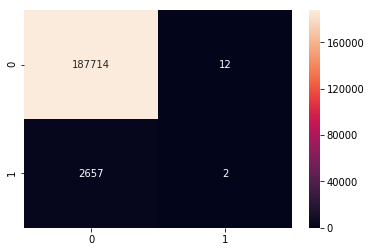

In [17]:
pred = log_pipe_scale.predict(X_val)
conf_matrix = confusion_matrix(y_val, pred)

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [20]:
score_model('Logistic_regression', ['recall','precision'], y_val, pred)

,model,recall,precision
0,Logistic_regression,0.000752,0.142857


## Defining Custom Threshold

In [0]:
df = pd.DataFrame(log_pipe_scale.predict_proba(X_val))

df['actual'] = y_val
df.loc[(df[1] >=0.4), 'pred'] = 1 
df.loc[(df[1] <0.4), 'pred'] = 0 

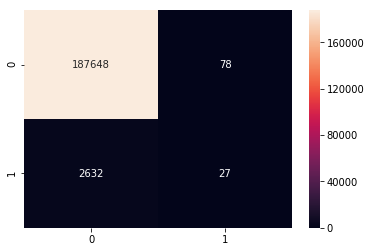

In [22]:
conf_matrix = confusion_matrix(df['actual'], df['pred'])

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [23]:
score_model('Logistic_regression', ['recall','precision'], df['actual'], df['pred'])

,model,recall,precision
0,Logistic_regression,0.010154,0.257143
